,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


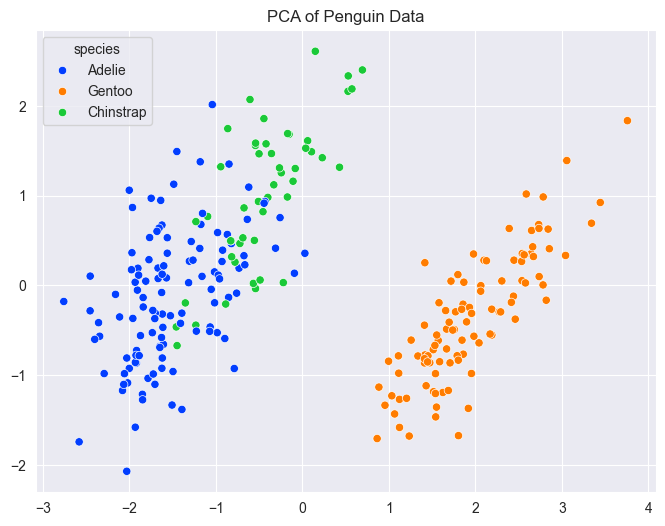

In [261]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('penguins.csv')
df.replace('?', pd.NA, inplace=True)
df = df.dropna()
display(df.head())

X = df[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = df['species']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="bright")
plt.title('PCA of Penguin Data')
plt.show()


The PCA results show that the Gentoo species is well-separated from the Adelie and Chinstrap species, which are overlapping. This suggests that the Gentoo species can be distinguished using the PCA-reduced features, while the Adelie and Chinstrap species are less distinct in the 2D space.

Pairwise Confusion Matrix (Training Data):
 [[41878  3120]
 [ 5040 20984]]
Pairwise Confusion Matrix (Testing Data):
 [[2570  356]
 [ 404 1092]]
Pairwise Accuracy on Training Data:  0.8851060234856805
Pairwise Accuracy on Testing Data:  0.8281320669380371


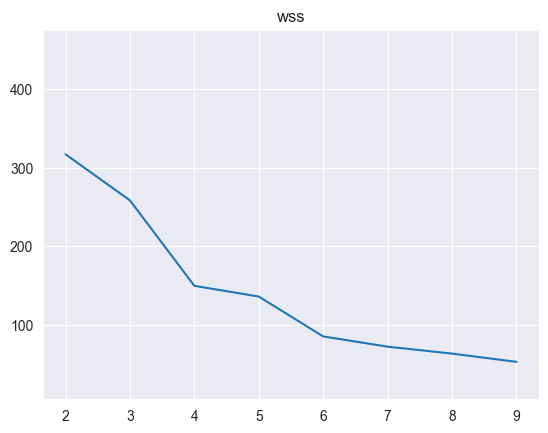

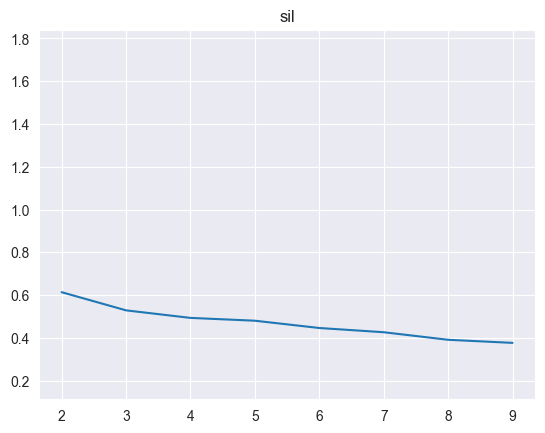

In [262]:
from sklearn.metrics import pair_confusion_matrix

wss_values = []
sil_values = []

for k in range(2, 10):
    clusters = KMeans(n_clusters=k).fit(X_train_pca)
    wss_values.append(clusters.inertia_)
    if k > 1: sil_values.append(silhouette_score(X_train_pca, clusters.predict(X_train_pca)))

plt.plot(range(2,10), wss_values)
plt.ylim(min(wss_values) * 0.1, max(wss_values) * 1.5)
plt.title("wss")
plt.figure()
plt.ylim(min(sil_values) * 0.3, max(sil_values) * 3)
plt.title("sil")
plt.plot(range(2,10), sil_values)

clusters = KMeans(n_clusters=3).fit(X_train_pca)

y_train_pred = clusters.predict(X_train_pca)
y_test_pred = clusters.predict(X_test_pca)


train_conf_matrix = pair_confusion_matrix(y_train, y_train_pred)
test_conf_matrix = pair_confusion_matrix(y_test, y_test_pred)

print("Pairwise Confusion Matrix (Training Data):\n", train_conf_matrix)
print("Pairwise Confusion Matrix (Testing Data):\n", test_conf_matrix)

def pairwise_accuracy(conf_matrix):
    return (conf_matrix[0][0] + conf_matrix[1][1]) / conf_matrix.sum()

print("Pairwise Accuracy on Training Data: ", pairwise_accuracy(train_conf_matrix))
print("Pairwise Accuracy on Testing Data: ", pairwise_accuracy(test_conf_matrix))


My K-Means clustering accuracy of 0.89 indicates that the clustering algorithm has done a good job in separating the species. 
- The wss chart further validates this result by suggesting 3 is the k value we should use as it is the "elbow". 3 is the elbow as the drop from 2 to 3 is much more dramatic than the drop from 3 to 4.
- The sil chart, however, does not validate this result as it suggests 2 is our optimal k value as it has the greatest silhouette_score.

In [263]:
from sklearn.preprocessing import OneHotEncoder
from sklearn_som.som import SOM
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import numpy as np

df_cat = df[['island', 'sex']]
encoder = OneHotEncoder()
X_cat_encoded = encoder.fit_transform(df_cat)

X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_cat_encoded, y, test_size=0.2, random_state=42)

som = SOM(m=1, n=10, dim=X_train.shape[1]) 

som_train_predictions = som.predict(X_train).reshape(-1, 1)
som_test_predictions = som.predict(X_test).reshape(-1, 1)
print(X_train_cat.shape, som_train_predictions.shape)
aug_X_train = np.hstack([X_train_cat.toarray(), som_train_predictions])
aug_X_test = np.hstack([X_test_cat.toarray(), som_test_predictions])

pipeline = Pipeline([
    ('classifier', MLPClassifier(max_iter=3000))
])
cv_params = {
    'classifier__hidden_layer_sizes': [(10,), (20,), (40,), (80,),
                                       (10, 5), (20, 10), (40, 20), (80, 40)],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1]  
}

cv = GridSearchCV(pipeline, cv_params, n_jobs=-1, cv=5)
cv.fit(aug_X_train, y_train)

print("Best parameters found:", cv.best_params_)
print("Training accuracy:", accuracy_score(y_train, cv.predict(aug_X_train)))
print("Testing accuracy:", accuracy_score(y_test, cv.predict(aug_X_test)))



(267, 6) (267, 1)
Best parameters found: {'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (20, 10)}
Training accuracy: 0.7191011235955056
Testing accuracy: 0.7014925373134329



My MLP accuracies suggest that my MLP model is performing okay. The small differences between the training and testing accuracy scores suggests that the model can generalize well. However, the accuracy score could certainly be improved upon.
